## 가상화폐의 단순 등락이 아닌 등락 정도 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import FinanceDataReader as fdr

import os

from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### 1. 데이터 불러오기

In [2]:
usd = fdr.DataReader('USD/KRW', '1995-01-01')
df_upbit = pd.read_csv('./upbit_daily.csv', index_col=0)

In [3]:
investing_dir = './investing_data/'
investing_paths = os.listdir(investing_dir)

In [4]:
investing_list = []

for path in investing_paths :
    temp_df = pd.read_csv(investing_dir + path, index_col='Date',  parse_dates=True)
    temp_df['Name'] = path[:-36]
    temp_df.sort_index(inplace=True)
    investing_list.append(temp_df)
    
df_investing = pd.concat(investing_list)

In [5]:
df_investing

,Price,Open,High,Low,Vol.,Change %,Name
Date,,,,,,,
2017-12-31,0.71,0.59,0.74,0.59,17.22M,20.34%,Cardano
2018-01-01,0.7022,0.71,0.715,0.632,17.95M,-1.10%,Cardano
2018-01-02,0.762,0.7022,0.8,0.675,10.97M,8.52%,Cardano
2018-01-03,1.08,0.9782,1.09,0.8882,20.23M,41.73%,Cardano
2018-01-04,1.1043,1.1,1.35,1.05,19.60M,2.25%,Cardano
...,...,...,...,...,...,...,...
2021-11-29,205.5,199.6,209.3,195.4,811.22K,2.96%,Litecoin
2021-11-30,208.1,205.6,218.9,197.5,1.03M,1.27%,Litecoin
2021-12-01,208.8,207.8,217.6,205.6,674.03K,0.34%,Litecoin


### 2. 데이터 전처리

In [6]:
name_list = ['Algorand', 'Axie Infinity', 'Bitcoin Cash', 'Bitcoin', 'Cardano', 'Chainlink', 'Cosmos',\
            'Crypto.com Coin', 'Decentraland', 'Dogecoin', 'Ethereum Classic', 'Ethereum', 'Hedera', 'Litecoin',\
            'Polkadot', 'Polygon', 'Solana', 'Stellar', 'TerraUSD', 'Tezos', 'The Sandbox', 'THETA',\
            'TRON', 'VeChain', 'XRP']
code_list = ['ALGO', 'AXS', 'BTH', 'BTC', 'ADA', 'LINK', 'ATOM', 'CRO', 'MANA', 'DOGE', 'ETC', 'ETH', 'HBAR', 'LTC',\
            'DOT', 'MATIC', 'SOL', 'XLM', 'UST', 'XTZ', 'SAND', 'THETA', 'TRX', 'VET', 'XRP']

code_dict = {
    'Name' : name_list,
    'Code' : code_list
}

In [7]:
df_codes = pd.DataFrame(code_dict)

In [8]:
df_investing.reset_index(inplace=True)
df_investing = pd.merge(df_investing, df_codes, on='Name', how='outer')
df_investing.set_index('Date', inplace=True)

In [9]:
df_upbit['Code'] = df_upbit.market.apply(lambda x : x.split('-')[1])
df_upbit = pd.merge(df_upbit, df_codes, on='Code', how='left')

In [10]:
upbit_columns = ['candle_date_time_utc', 'opening_price', 'high_price', 'low_price', 'trade_price',
       'candle_acc_trade_price', 'Code', 'Name']
df_upbit = df_upbit[upbit_columns]

In [11]:
df_upbit.columns = ['Date', 'Open', 'High', 'Low', 'Price',
       'Volume', 'Code', 'Name']

In [12]:
df_upbit['Date'] = pd.to_datetime(df_upbit.Date)
df_upbit.set_index('Date', inplace=True)

In [13]:
df_upbit

,Open,High,Low,Price,Volume,Code,Name
Date,,,,,,,
2020-10-05,24.9,25.5,23.4,24.0,1.224960e+09,ZIL,NaN
2020-10-04,21.8,25.2,21.4,24.9,1.229447e+09,ZIL,NaN
2020-10-03,21.2,23.0,20.4,21.8,7.225800e+08,ZIL,NaN
2020-10-02,22.8,22.9,19.4,21.2,2.149693e+09,ZIL,NaN
2020-10-01,22.8,24.1,21.3,22.8,1.313784e+09,ZIL,NaN
...,...,...,...,...,...,...,...
2021-04-28,6400.0,6580.0,5905.0,6135.0,2.165054e+10,XTZ,Tezos
2021-04-27,6200.0,6435.0,6075.0,6400.0,2.548068e+10,XTZ,Tezos
2021-04-26,5450.0,6235.0,5300.0,6205.0,2.613041e+10,XTZ,Tezos


In [14]:
sort_list = []
for code in df_upbit.Code.unique():
    temp_df = df_upbit[df_upbit.Code == code].sort_index()
    sort_list.append(temp_df)
    
df_upbit = pd.concat(sort_list)

#### 데이터 합치기

In [35]:
%%time
left_columns = ['Price', 'Volume']
right_columns = ['Price', 'Code', 'Name']
merged_df = []
for name in df_investing.Code.unique():
    
    left = df_upbit[df_upbit.Code == name][left_columns]
    right = df_investing[df_investing.Code == name][right_columns]
    
    temp = pd.merge(left, right, how='inner', suffixes=('_upbit', '_investing'),
            left_index=True, right_index=True)
    
    temp = pd.merge(temp, usd.Close, how='left', left_index=True, right_index=True)
    
    temp.sort_index(inplace=True)
    merged_df.append(temp)

CPU times: user 273 ms, sys: 2.62 ms, total: 276 ms
Wall time: 275 ms


In [36]:
merged_df = pd.concat(merged_df)
merged_df.columns = ['Price_upbit', 'Volume', 'Price_investing', 'Code', 'Name', 'Exchange_rate']
merged_df.ffill(inplace=True)
merged_df['Price_investing'] = merged_df.Price_investing.apply(lambda x : pd.to_numeric(str(x).replace(',', '')))
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18233 entries, 2017-12-31 to 2021-11-09
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price_upbit      18233 non-null  float64
 1   Volume           18233 non-null  float64
 2   Price_investing  18233 non-null  float64
 3   Code             18233 non-null  object 
 4   Name             18233 non-null  object 
 5   Exchange_rate    18232 non-null  float64
dtypes: float64(4), object(2)
memory usage: 997.1+ KB


In [37]:
merged_df['Price_inves_won'] = merged_df['Price_investing'] * merged_df['Exchange_rate']
merged_df['KimP']  = merged_df['Price_upbit'] / merged_df['Price_inves_won']
merged_df

,Price_upbit,Volume,Price_investing,Code,Name,Exchange_rate,Price_inves_won,KimP
Date,,,,,,,,
2017-12-31,986.0,8.740969e+11,0.7100,ADA,Cardano,NaN,NaN,NaN
2018-01-01,987.0,5.195622e+11,0.7022,ADA,Cardano,1066.60,748.966520,1.317816
2018-01-02,1050.0,4.955807e+11,0.7620,ADA,Cardano,1063.21,810.166020,1.296031
2018-01-03,1545.0,9.290652e+11,1.0800,ADA,Cardano,1064.80,1149.984000,1.343497
2018-01-04,1755.0,8.579506e+11,1.1043,ADA,Cardano,1062.28,1173.075804,1.496067
...,...,...,...,...,...,...,...,...
2021-11-05,242000.0,1.422169e+10,200.2790,LTC,Litecoin,1181.05,236539.512950,1.023085
2021-11-06,239700.0,9.962796e+09,197.6000,LTC,Litecoin,1181.05,233375.480000,1.027100
2021-11-07,244700.0,8.479420e+09,201.9000,LTC,Litecoin,1181.05,238453.995000,1.026194


### 3. 머신러닝 적용

In [38]:
def apply_categorical(sr) :
    if -0.01 <= sr < 0.01 :
        return 0
    elif 0.01 <= sr < 0.05 :
        return 1
    elif 0.05 <= sr < 0.10 :
        return 2
    elif 0.10 <= sr < 0.20 :
        return 3
    elif 0.20 <= sr :
        return 4
    elif -0.05 <= sr < -0.01 :
        return 5
    elif -0.10 <= sr < -0.05 :
        return 6
    elif -0.20 <= sr < -0.10 :
        return 7
    elif sr < -0.20 :
        return 8

In [39]:
def apply_y_category(n):
    if -0.05 <= n < 0.05 :
        return 1
    
    elif 0.05 <= n :
        return 2
        
    elif n <= -0.05 :
        return 0

In [40]:
WINDOWS_SIZE = 20


X = []
kimp = []
y = []


for code in merged_df.Code.unique():
    temp_df = merged_df[merged_df.Code == code][['Price_upbit', 'KimP']]
    temp_df['Price_upbit'] = temp_df['Price_upbit'].pct_change()
    temp_df.dropna(inplace=True)

    for i in range(len(temp_df) - WINDOWS_SIZE) : 
        X.append(temp_df.iloc[[i + j for j in range(WINDOWS_SIZE)]]['Price_upbit'].values)
        kimp.append(temp_df.iloc[[i + j for j in range(WINDOWS_SIZE)]]['KimP'].values)
        y.append(apply_y_category(temp_df.iloc[i+WINDOWS_SIZE]['Price_upbit']))


X = np.array(X)
y = np.array(y)
kimp = np.array(kimp)

In [41]:
merged_df.Code.unique()

array(['ADA', 'XTZ', 'XRP', 'XLM', 'DOGE', 'ATOM', 'MATIC', 'AXS', 'ETC',
       'SAND', 'HBAR', 'LINK', 'VET', 'SOL', 'BTC', 'ETH', 'TRX', 'CRO',
       'THETA', 'DOT', 'MANA', 'LTC'], dtype=object)

(array([ 2202.,     0.,     0.,     0.,     0., 13007.,     0.,     0.,
            0.,  2566.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

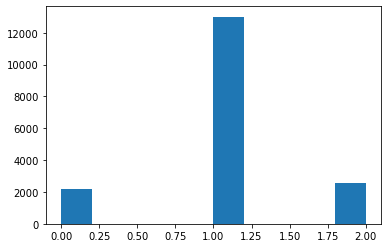

In [42]:
plt.hist(y)

In [43]:
temp_df = pd.DataFrame(X)
for column in temp_df.columns :
    temp_df[column] = temp_df[column].apply(apply_categorical)

In [44]:
temp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,2,4,3,6,0,5,6,7,7,6,4,5,7,5,8,2,0,1,2
1,2,4,3,6,0,5,6,7,7,6,4,5,7,5,8,2,0,1,2,7
2,4,3,6,0,5,6,7,7,6,4,5,7,5,8,2,0,1,2,7,6
3,3,6,0,5,6,7,7,6,4,5,7,5,8,2,0,1,2,7,6,6
4,6,0,5,6,7,7,6,4,5,7,5,8,2,0,1,2,7,6,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17770,5,0,0,1,2,5,5,1,5,1,1,6,1,1,5,0,1,0,1,0
17771,0,0,1,2,5,5,1,5,1,1,6,1,1,5,0,1,0,1,0,0
17772,0,1,2,5,5,1,5,1,1,6,1,1,5,0,1,0,1,0,0,0
17773,1,2,5,5,1,5,1,1,6,1,1,5,0,1,0,1,0,0,0,1


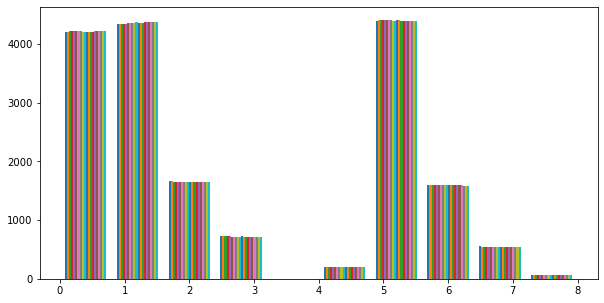

In [45]:
plt.figure(figsize=(10,5))
plt.hist(temp_df)
plt.show()

In [46]:
import tensorflow
X = tensorflow.keras.utils.to_categorical(temp_df)

In [47]:
X.shape, y.shape

((17775, 20, 9), (17775,))

In [48]:
X = X.reshape(X.shape[0], -1)

In [49]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17770,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17773,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
pd.DataFrame(kimp)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.317816,1.296031,1.343497,1.496067,1.537845,1.486211,1.511518,1.569689,1.549011,1.329781,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699
1,1.296031,1.343497,1.496067,1.537845,1.486211,1.511518,1.569689,1.549011,1.329781,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989
2,1.343497,1.496067,1.537845,1.486211,1.511518,1.569689,1.549011,1.329781,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978
3,1.496067,1.537845,1.486211,1.511518,1.569689,1.549011,1.329781,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978,1.124486
4,1.537845,1.486211,1.511518,1.569689,1.549011,1.329781,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978,1.124486,1.112152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17770,1.042195,1.045898,1.040398,1.042128,1.028425,1.042217,1.041072,1.036340,1.039509,1.034805,1.039639,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949
17771,1.045898,1.040398,1.042128,1.028425,1.042217,1.041072,1.036340,1.039509,1.034805,1.039639,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085
17772,1.040398,1.042128,1.028425,1.042217,1.041072,1.036340,1.039509,1.034805,1.039639,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085,1.027100
17773,1.042128,1.028425,1.042217,1.041072,1.036340,1.039509,1.034805,1.039639,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085,1.027100,1.026194


In [51]:
X = pd.concat([pd.DataFrame(X), pd.DataFrame(kimp)], axis=1)

In [52]:
X

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.377233,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.441608,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.405985,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.320767,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978,1.124486
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.335521,1.229558,1.295317,1.235724,1.263244,1.243699,1.181989,1.192978,1.124486,1.112152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17770,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.039639,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949
17771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.047010,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085
17772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.029336,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085,1.027100
17773,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.019798,1.015842,1.006233,1.012980,0.997104,1.009854,1.014949,1.023085,1.027100,1.026194


#### 머신러닝 적용

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [54]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13331, 200), (13331,), (4444, 200), (4444,))

In [62]:
X_train.iloc[0]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
15    0.994753
16    0.999928
17    1.003529
18    0.991250
19    0.997154
Name: 4440, Length: 200, dtype: float64

In [55]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(n_estimators=1000)
gbr = GradientBoostingClassifier()

knn.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbr.fit(X_train, y_train)

CPU times: user 53.2 s, sys: 93.5 ms, total: 53.3 s
Wall time: 53.4 s


GradientBoostingClassifier()

In [56]:
%%time
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))
print()
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))
print()
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.8324956867451804
0.7184968496849685

1.0
0.7551755175517552

0.775785762508439
0.7407740774077408
CPU times: user 13.2 s, sys: 3.14 s, total: 16.4 s
Wall time: 7.93 s


In [76]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
16853,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.024316,1.024177,1.011958,0.999421,0.999346,0.999908,0.993745,0.986754,0.986768,0.987123
17082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.986577,0.991817,0.993550,0.977870,0.997026,0.995361,0.995470,0.994044,0.999989,1.006270
14048,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.002957,0.996693,0.992131,0.994273,0.992981,0.994338,0.999213,0.997235,0.991106,1.013392
11536,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005961,0.990257,0.989806,0.993904,1.000169,1.005517,0.999881,0.996833,0.998272,1.002319
13597,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.020877,1.018308,1.022182,1.036377,1.024951,1.034045,1.024792,1.036607,1.038225,1.047422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6952,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.940511,0.939207,0.914742,0.897537,0.941909,0.961693,1.031038,0.982412,0.984671,0.962958
1794,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.035120,1.038710,1.041502,1.046734,1.034737,1.033095,1.028520,1.027095,1.035621,1.029403
2006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.034579,1.038913,1.042612,1.027011,1.024744,1.017342,1.011867,1.023785,1.014559,0.995923
2781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.978466,0.970935,0.981602,0.983734,0.989451,0.989112,0.981636,0.981082,0.982551,0.977959


In [66]:
import pickle
pickle.dump(rfc, open('rfc', 'wb'))

### 4. 결과확인

In [75]:
preds = rfc.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.81      0.22      0.34       581
           1       0.75      0.99      0.85      3211
           2       0.73      0.09      0.17       652

    accuracy                           0.76      4444
   macro avg       0.77      0.43      0.45      4444
weighted avg       0.76      0.76      0.69      4444



In [77]:
def rjitt(arr):
    stdev = .05*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

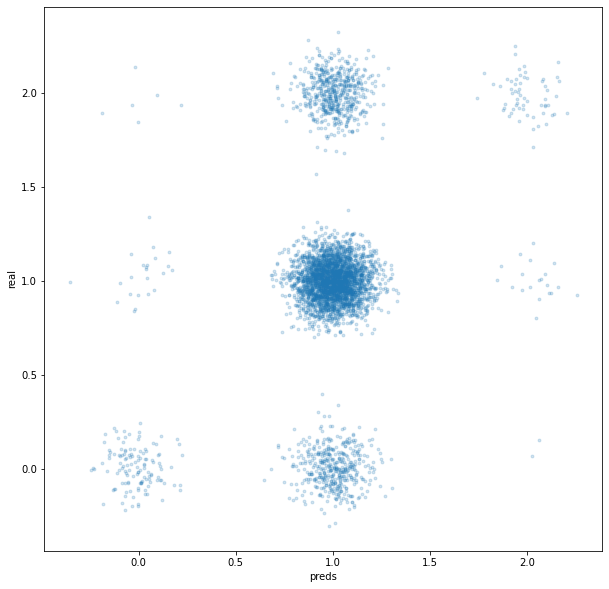

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(rjitt(preds), rjitt(y_test), s=8, alpha=0.2)
plt.xlabel('preds')
plt.ylabel('real')
plt.show()